In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## The Finite Sites model with distinguishable individuals and loci

We let $q_i$ be the likelihood of the cofiguration associated with matrix $i$, whereby the set of all $0-1$ matricees with 2 columns and no more than 2 rows are indexed as follws:
$$
0 : \begin{bmatrix} 0 & 0 \end{bmatrix} \quad
1 : \begin{bmatrix} 0 & 1 \end{bmatrix} \quad
2 : \begin{bmatrix} 1 & 0 \end{bmatrix} \quad
3 : \begin{bmatrix} 1 & 1 \end{bmatrix} \\
4 : \begin{bmatrix} 0 & 0 \\
                    0 & 0 \end{bmatrix} \\
5 : \begin{bmatrix} 1 & 0 \\
                    0 & 0 \end{bmatrix} \quad
6 : \begin{bmatrix} 0 & 1 \\
                    0 & 0 \end{bmatrix} \quad
7 : \begin{bmatrix} 0 & 0 \\
                    1 & 0 \end{bmatrix} \quad
8 : \begin{bmatrix} 0 & 0 \\
                    0 & 1 \end{bmatrix} \\
9 : \begin{bmatrix} 1 & 1 \\
                    0 & 0 \end{bmatrix} \quad
10 : \begin{bmatrix} 1 & 0 \\
                     1 & 0 \end{bmatrix} \quad
11 : \begin{bmatrix} 1 & 0 \\
                     0 & 1 \end{bmatrix} \quad
12 : \begin{bmatrix} 0 & 1 \\
                     1 & 0 \end{bmatrix} \quad
13 : \begin{bmatrix} 0 & 1 \\
                     0 & 1 \end{bmatrix} \quad
14 : \begin{bmatrix} 0 & 0 \\
                     1 & 1 \end{bmatrix} \\
15 : \begin{bmatrix} 1 & 1 \\
                     1 & 0 \end{bmatrix} \quad
16 : \begin{bmatrix} 1 & 1 \\
                     0 & 1 \end{bmatrix} \quad
17 : \begin{bmatrix} 1 & 0 \\
                     1 & 1 \end{bmatrix} \quad
18 : \begin{bmatrix} 0 & 1 \\
                     1 & 1 \end{bmatrix} \\
19 : \begin{bmatrix} 1 & 1 \\
                     1 & 1 \end{bmatrix}
$$

The Griffiths-tavare recursions then prescribe a system linear equations which the likelihoods must fulfill, namely:
$$
q_i =
\begin{cases}
\pi(i) 
&\text{ if } i < 4
\\
\frac{2-1}{2-1+\theta} \sum_{\substack{j \\ j = \operatorname{coal}(i)}} q(j)
\quad + \frac{\theta}{2 - 1 + \theta} \sum_{\substack{j \\ d(i,j) = 1}} \frac{1}{4} q(j)
&\text{ if } i \leq 3
\end{cases}
$$
Whereby $\pi$ is some probability-distribution on $\{0,1,2,3\}$. The above is a special case of the griffiths-tavare-recursions, if one considers both sites and sequences to be distinguishable, all mutations to be state changing, and all loci and sites equally likely to be affected by a mutation.

The above equations can be encoded as a linear system of the form
$$Ax = b$$
by letting
$$
A_{ij} =
\begin{cases}
 1 &\text{ if } i=j \leq 3
\\
-1 &\text{ if } i=j > 3
\\
\frac{2-1}{2-1+\theta} &\text{ if } j \leq 3 < i \text{ and } j = \operatorname{coal}(i)
\\
\frac{\theta}{2-1+\theta}\frac{1}{4} &\text{ if } 3 < i,j  \text{ and } d(i,j) = 1
\\
0 &\text{ else}
\end{cases}
\qquad\qquad
b_i =
\begin{cases}
 \pi(i) &\text{ if } i < 4
\\
 0 &\text{ else}
\end{cases}
\quad
$$
Below, we solve this system for $\pi \in \{ \delta_0 , \frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3) \}$, and varying values of $\theta$.

### Building a solver
We start by encode which matricees are one mutation-evant appart, and which are one coalescence-event appart:

In [2]:
'''j \in d_coal[i] signifies that matrix j can be obtained by coalescing two rows from i'''
d_coal_FS = {4:set([0]) ,
          10:set([2]),
          13:set([1]),
          19:set([3]) }

In [3]:
'''
j in d_mut_FS[i] signifies that j and i are 1 mutation-event appart in the finite sites-model.
Note that the recursion terminates when N = 1, and hence, that for instance 1 in d_mut_FS[0] does not hold.
'''
d_mut_FS = {
         4:set([5,6,7,8]),
         5:set([4,9,10,11]),
         6:set([4,9,12,13]),
         7:set([4,10,12,14]),
         8:set([4,11,13,14]),
         9:set([5,6,15,16]),
         10:set([5,7,15,17]),
         11:set([5,8,16,17]),
         12:set([6,7,15,18]),
         13:set([6,8,16,18]),
         14:set([7,8,17,18]),
         15:set([9,10,12,19]),
         16:set([9,11,13,19]),
         17:set([10,11,14,19]),
         18:set([12,13,14,19]),
         19:set([15,16,17,18])
        }

def checkSymmetry(d):
    '''
    An auxiliary function which will catch the odd input-error :p
    Returns True if (j in d[i]) implies (i in d[j]) for all i and j, and Flase if not
    '''
    for key,val in d.iteritems():
        for j in val:
            if not (key in d[j]):
                #print key,val,j,d[j]
                return False
    return True

checkSymmetry(d_mut_FS)

True

We now proceed to implement functions $\theta \mapsto A$ and $\pi \mapsto b$:

In [4]:
def coeficientMatrix(theta, d_mut = d_mut_FS, d_coal = d_coal_FS, Nr = lambda x: 1.0, Nc = lambda x: 1.0):
    '''
    returns the coeffieient matrix for the linear system given by the griffiths-tavare-recursions expressed as a
    homogeneous linear system.
    
    theta : a non-negative float.
    
    d_mut : a dictionary where d_mut[i] contains a list of all indices of matrices connected to i by one mutation.
    
    d_coal: a dictionary where d_mut[i] contains a set of all indices of matrices may be transformed into matrix i by
            merging two identical rows; e.g. d_coal[0] == set([4]).
            
    Note that the correct coefficient matrix is only returned if the matricees are as outlined in the above comment!
    '''
    dim1 = len(d_coal)
    dim = len(d_mut) + len(d_coal)
    theta = float(theta)
    
    if theta < 0:
        raise ValueError('\'theta\' should be a non-negative number.')
    
    if not checkSymmetry(d_mut):
        raise UserWarning('warning: d_mut is not symmetric.')
        
        
    #bdr = np.eye(4,dim)
    A = np.r_[np.eye(dim1,dim),
              np.zeros((dim-dim1,dim))]

    for i in range(dim1,dim):
        A[i,i] = -1.0
    
    for i,neigbours in d_mut.iteritems():
        n = 2
        p_mut = ( theta / ( n-1 + theta ) )
        for j in neigbours:
            A[i,j] = p_mut * ( Nr(j) * Nc(j) / 4.0 )
    
    for i,neighbours in d_coal.iteritems():
        n = 2
        p_coal = ( n-1 ) / (theta + n-1)
        for j in neighbours:
            A[i,j] = p_coal
            
    return A

def inhomogeneity(bdr_cnd,zeroDim = 16):
    return np.r_[bdr_cnd,np.zeros(zeroDim)]

Using this, we can implement a map $(\theta,\pi) \mapsto (x,A,b)$ s.t. $Ax = b$.

In [5]:
def solve_GT_recursions(thetas,pis):
    '''
    Solve the Griffiths-and tavare-recursions explicitly for any (theta,pi) such that theta is an element of thetas,
    and pi is an element of pis.
    
    Returns three dictionaries:
      solutions,
      Ms,
      bs,
    which are indexed by keysets thetas, pis and ((theta,pi) for theta in thetas for pi in pis) respectively.
    There satisfy that the linear equation
    
      bs[pi] = Ms[theta] * solutions[(theta,pi)]
    
    holds for any choice of pi in pis and theta in thetas.
    '''
    solutions = {}
    Ms = {}
    bs = {}
    for pi in pis:
        b = inhomogeneity(pi)
        bs[pi] = b
        for theta in thetas:
            M = coeficientMatrix(theta)
            Ms[theta] = M
            solutions[(theta,pi)] = np.linalg.solve(M,b)
    return solutions,Ms,bs

### Using the solver

We now use the solver to explore how theta affects the relative likelihoods of different matricees.

In [6]:
thetas = np.logspace(-4,3,num=100)
pi1 = (0.25,0.25,0.25,0.25)
pi2 = (1.0,0,0,0)
pis = (pi1,pi2)

solutions,Ms,bs = solve_GT_recursions(thetas,pis)

We Proceed to produce plots and log-plots showing the likelihoods of $q_i$ for different values of $i$, as a function onf theta for $\pi \in \{ \delta_0 , \frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3) \}$. We do not plot $q_i$ for all values of $i$, but any value which is not plotted is identical to one which is (working out which index represents an index that is not plottet from the basic model is quite simple).

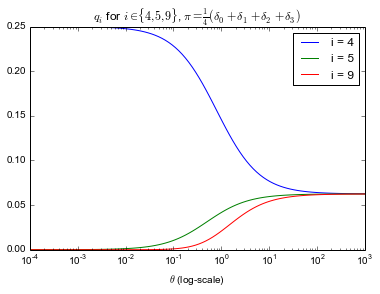

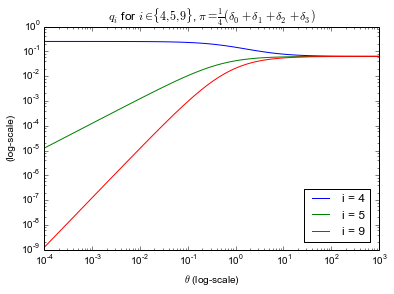

In [7]:
plt.figure(1)
#plt.subplot(211)
for i in (4,5,9):
    likelihhods = [solutions[(theta,pi1)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
#plt.legendnd()
plt.legend()
plt.xscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9\\}$, $\pi = \\frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3)$')
plt.show()
plt.close()

plt.figure(2)
#plt.subplot(212)
for i in (4,5,9):
    likelihhods = [solutions[(theta,pi1)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
#plt.legendnd()
plt.legend(bbox_to_anchor=(0.99, 0.30))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.ylabel('(log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9\\}$, $\pi = \\frac{1}{4}(\delta_0 + \delta_1 + \delta_2 + \delta_3)$')
plt.show()
plt.close()

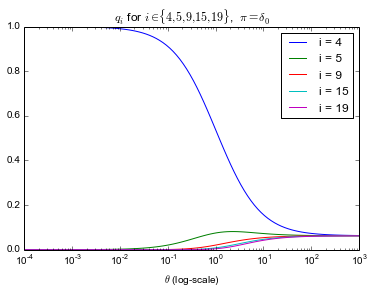

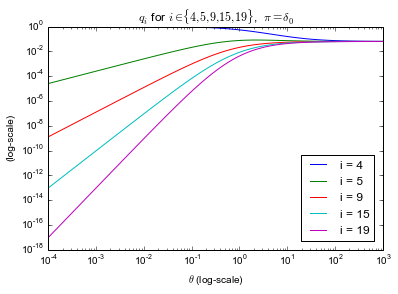

In [8]:
plt.figure(3)
for i in (4,5,9,15,19):
    likelihhods = [solutions[(theta,pi2)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
plt.xscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9,15,19\\}$,  $\pi = \delta_0$')
plt.legend()
plt.show()
plt.close()

plt.figure(3)
for i in (4,5,9,15,19):
    likelihhods = [solutions[(theta,pi2)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.ylabel('(log-scale)')
plt.title('$q_i$ for $i \\in \\{ 4,5,9,15,19\\}$,  $\pi = \delta_0$')
plt.legend(bbox_to_anchor=(0.99, 0.45))
plt.show()
plt.close()

Below is an old function whuch I don't use anymore, but did not have the heart to throw out.

In [9]:
def printOctaveCode(theta,bdr_cnd):
    '''
    Prints octave code, for solving the linear system.
    Not used by me anymore, as I opted in the end for doing everything in python, but i kept it, as I might use it later.
    '''
    floatToStr = lambda x : "%.16f"%x
    
    b = np.r_[bdr_cnd[0],bdr_cnd[1],bdr_cnd[2],bdr_cnd[3],np.zeros(16)]
    M = coeficientMatrix(theta, d_mut, d_coal, d_rows)
    b_str = 'b = [%s]'%'\n     '.join(map(floatToStr,b))
    M_lines = [ ', '.join(map(floatToStr,[M[i,j] for j in range(M.shape[1])])) for i in range(M.shape[0])]
    M_str = 'M = [%s]'%'\n     '.join(M_lines)
    solveStr = 'linsolve(M,b)'
    
    print b_str,'\n'
    print M_str,'\n'
    print solveStr
#printOctaveCode(float(10**9),pi)

## The Finite Sites model with distinguishable loci and indistinguishable individuals

*Should I do this model as well? At the moment it does not have high priority.*

## The Almost Infinite Sites model

We may think of the Almost Infinite Sites model as a Finite Sites model with indistinguishable loci and individuals. Hence, we let $\sim$ denote the following equivalence relation
$$
A \sim B :\Leftrightarrow \exists \sigma_1 \sigma_2 \in \mathcal{S}_2: A = P_{\sigma_1} B P_{\sigma_2}
$$
Letting $[ \, \cdot \, ]_\sim$ denote equivalence-classes w.r.t. $\sim$, e.g.

$$
\left[
\begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}
\right]_\sim
=
\left\{
\begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} ,
\begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} ,
\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix} ,
\begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix}
\right\}
$$

it follows, that we can enumerate the state-space of the Almost Infinite Sites modell as follows:

$$
0 : \left[ \begin{bmatrix} 0 & 0 \end{bmatrix} \right]_\sim \quad
1 : \left[ \begin{bmatrix} 1 & 0 \end{bmatrix} \right]_\sim \quad
2 : \left[ \begin{bmatrix} 1 & 1 \end{bmatrix} \right]_\sim \\
3 : \left[ \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix} \right]_\sim \\
4 : \left[ \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \right]_\sim \\
5 : \left[ \begin{bmatrix} 1 & 1 \\ 0 & 0 \end{bmatrix} \right]_\sim \quad
6 : \left[ \begin{bmatrix} 1 & 0 \\ 1 & 0 \end{bmatrix} \right]_\sim \quad
7 : \left[ \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \right]_\sim \\
8 : \left[ \begin{bmatrix} 1 & 1 \\ 1 & 0 \end{bmatrix} \right]_\sim \\
9 : \left[ \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} \right]_\sim
$$

We note that since the number of members of different equivalence-classes is different for different matrices, the coefficients in the recursion are not as straightforward. To compute them, we may use our Almost-infinite sites recursion-formula [see article], which in the case of a 2-letter alphabet with all mutations being state-changing reduces to:

$$
q_i
 =
 \begin{cases}
 \pi_i
 &\text{ if $i < 3$}
 \\
 \frac{2-1}{2-1+\theta}
 \sum_{\substack{j < 3 \\ j = \operatorname{coal}(i)}} q_j
 \;
 +
 \;
 \frac{\theta}{2 - 1 + \theta}
 \sum_{\substack{3 \leq j \\ d(i,j) = 1}}
 \operatorname{multiplicity}(i \rightarrow j)
 \frac{ \mathcal{N}^{\mathrm{r}}_{j\rightarrow i} }{2}
 \frac{ \mathcal{N}^{\mathrm{c}}_{j\rightarrow i} }{2}
 q_j
 &\text{ if $3 \leq i$}
 \end{cases}
$$

Whereby
$
\mathcal{N}^{\mathrm{r}}_{j\rightarrow i}
=
\begin{cases}
1 &\text{ if $j$ has 2 different rows.}\\
2 &\text{ if $j$ has 2 identical rows.}
\end{cases}
$
and 
$
\mathcal{N}^{\mathrm{c}}_{j\rightarrow i}
=
\begin{cases}
1 &\text{ if $j$ has 2 different columns.}\\
2 &\text{ if $j$ has 2 identical columns.}
\end{cases}
$

For purposes of clarification, we here point out that neither the rows or collumns of $\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$ are to be considered identical. $\operatorname{multiplicity}(i \rightarrow j)$ corresponds to the number of entries in matrix $i$ which can be flipped in order to obtain matrix $j$. In the 2x2 case, $\operatorname{multiplicity}(i \rightarrow j) = \delta_{7,i}$ holds. Note that this factor does not appear in the formulation used in the article, as the index-set of the corresponding sum is expanded in a way, which obviates it.

### Building a solver

In [10]:
def Nr_AIS(j):
#     return 1.0 + float(j in (3,6,9))
    return 1.0 + float(j in (3,6,9,7)) # This is a HACK. The factor in front 

def Nc_AIS(j):
    return 1.0 + float(j in (3,5,9))

In [11]:
d_coal_AIS = {
    3:set([0]),
    6:set([1]),
    9:set([2])
}

In [12]:
d_mut_AIS = {
    3:set([4]),
    4:set([3,5,6,7]),
    5:set([4,8]),
    6:set([4,8]),
    7:set([4,8]),
    8:set([5,6,7,9]),
    9:set([8])
}
checkSymmetry(d_mut_AIS)

True

This is really all we need to implement the explicit solution of the almost infinite sites model.

In [13]:
pi1_AIS = [0.25, 0.5, 0.25]
pi2_AIS = [1.0 , 0.0 , 0.0]
M1_AIS = coeficientMatrix(1.0, d_mut = d_mut_AIS, d_coal = d_coal_AIS, Nr = Nr_AIS, Nc = Nc_AIS)
b1_AIS = inhomogeneity(pi1_AIS,7)
b2_AIS = inhomogeneity(pi2_AIS,7)
x1_AIS = np.linalg.solve(M1_AIS,b1_AIS)
x2_AIS = np.linalg.solve(M1_AIS,b2_AIS)
print x1_AIS,'\n',x2_AIS
print sum(x1_AIS[3:])
print sum(x2_AIS[3:])

[ 0.25        0.5         0.25        0.14583333  0.16666667  0.04166667
  0.29166667  0.04166667  0.16666667  0.14583333] 
[ 1.          0.          0.          0.5375      0.3         0.04166667
  0.04166667  0.04166667  0.03333333  0.00416667]
1.0
1.0


We check the numerical error:

In [14]:
from math import sqrt
err1 = np.dot(M1_AIS,x1_AIS) - b1_AIS
err2 = np.dot(M1_AIS,x2_AIS) - b2_AIS
print sqrt(sum(err1**2))/sqrt(sum(b1_AIS**2))
print sqrt(sum(err2**2))/sqrt(sum(b2_AIS**2))

1.24642829255e-16
1.62962475355e-17


The error seems to be on the order of machine precission; which is good.

We explore if the error is magnified/reduced when $\theta$ is varied.

In [15]:
# Case: theta is small
M0p001_AIS = coeficientMatrix(0.001, d_mut = d_mut_AIS, d_coal = d_coal_AIS, Nr = Nr_AIS, Nc = Nc_AIS)
x3_AIS = np.linalg.solve(M0p001_AIS,b2_AIS)
print "%.20f"%sum(x3_AIS[:2:-1])

1.00000000000000022204


In [16]:
#Case: theta is large
M10e9_AIS = coeficientMatrix(10.0**9, d_mut = d_mut_AIS, d_coal = d_coal_AIS, Nr = Nr_AIS, Nc = Nc_AIS)
x4_AIS = np.linalg.solve(M10e9_AIS,b2_AIS)
print "%.20f"%sum(x4_AIS[:2:-1])
print x4_AIS

1.00000005174863271229
[ 1.          0.          0.          0.0625      0.25000001  0.12500001
  0.12500001  0.12500001  0.25000001  0.0625    ]


Satisfies with these brief tests, we now *write* a solver, similar to for the Griffiths-tavare-case:

In [17]:
def solve_AIS_recursions(thetas,pis):
    '''
    Solve the Almost Infinite Sites-recursions explicitly for any (theta,pi) such that theta is an element of thetas,
    and pi is an element of pis.
    
    Returns three dictionaries:
      solutions,
      Ms,
      bs,
    which are indexed by keysets thetas, pis and ((theta,pi) for theta in thetas for pi in pis) respectively.
    There satisfy that the linear equation
    
      bs[pi] = Ms[theta] * solutions[(theta,pi)]
    
    holds for any choice of pi in pis and theta in thetas.
    '''
    solutions = {}
    Ms = {}
    bs = {}
    for pi in pis:
        b = inhomogeneity(pi,7)
        bs[pi] = b
        for theta in thetas:
            M = coeficientMatrix(theta, d_mut = d_mut_AIS, d_coal = d_coal_AIS, Nr = Nr_AIS, Nc = Nc_AIS)
            Ms[theta] = M
            solutions[(theta,pi)] = np.linalg.solve(M,b)
    return solutions,Ms,bs

### PLOTS!

As for the infinte-sites model, we proceed to produce plots and log-plots showing the likelihoods of $q_i$ for different values of $i$, as a function onf theta for $\pi \in \{ \delta_0 , \frac{1}{4}(\delta_0 + 2 \delta_1 + \delta_2) \}$. We do not plot $q_i$ for all values of $i$, but any value which is not plotted is identical to one which is (working out which index represents an index that is not plottet from the basic model is quite simple).

In [18]:
#thetas = np.logspace(-4,3,num=100)
pi1_AIS = (0.25, 0.5, 0.25)
pi2_AIS = (1.0 , 0.0 , 0.0)
pis_AIS = (pi1_AIS,pi2_AIS)

solutions_AIS,Ms_AIS,bs_AIS = solve_AIS_recursions(thetas,pis_AIS)

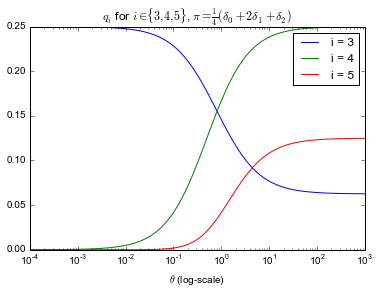

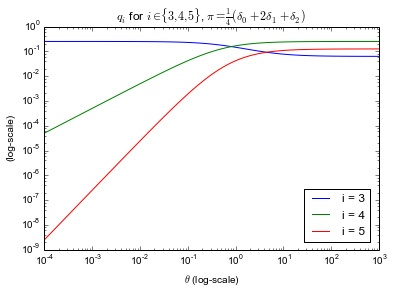

In [19]:
plt.figure(3)
#plt.subplot(211)
for i in (3,4,5):
    likelihhods = [solutions_AIS[(theta,pi1_AIS)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
#plt.legendnd()
plt.legend()
plt.xscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.title('$q_i$ for $i \\in \\{ 3,4,5\\}$, $\pi = \\frac{1}{4}(\delta_0 + 2\delta_1 + \delta_2)$')
plt.show()
plt.close()

plt.figure(4)
#plt.subplot(212)
for i in (3,4,5):
    likelihhods = [solutions_AIS[(theta,pi1_AIS)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
#plt.legendnd()
plt.legend(bbox_to_anchor=(0.99, 0.30))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.ylabel('(log-scale)')
plt.title('$q_i$ for $i \\in \\{ 3,4,5\\}$, $\pi = \\frac{1}{4}(\delta_0 + 2\delta_1 + \delta_2)$')
plt.show()
plt.close()

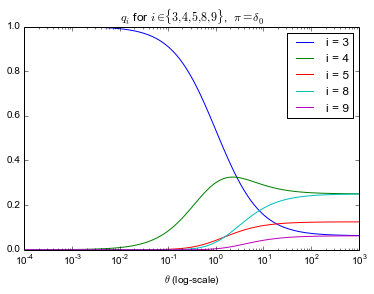

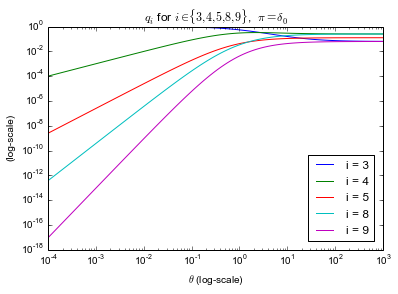

In [20]:
plt.figure(3)
for i in (3,4,5,8,9):
    likelihhods = [solutions_AIS[(theta,pi2_AIS)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
plt.xscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.title('$q_i$ for $i \\in \\{ 3, 4, 5, 8, 9\\}$,  $\pi = \delta_0$')
plt.legend()
plt.show()
plt.close()

plt.figure(4)
for i in (3,4,5,8,9):
    likelihhods = [solutions_AIS[(theta,pi2_AIS)][i] for theta in thetas]
    plt.plot(thetas,likelihhods, label = 'i = %i'%i)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\\theta$ (log-scale)')
plt.ylabel('(log-scale)')
plt.title('$q_i$ for $i \\in \\{ 3, 4, 5, 8, 9\\}$,  $\pi = \delta_0$')
plt.legend(bbox_to_anchor=(0.99, 0.45))
plt.show()
plt.close()

## Comparing results of the two models

One might note that we in the AIS-case do not observe all ptobabilities converging to the same value as is the case for the Finite-sites case. This is however simply due to the case that different equivalence-classes have different cardinalities. Hence, in order to compare the results of the two modells, we need to check if the equivalence class $A$ is assigned the same probability by the AIS-recursions as the sum of the probabilities assigned to its individual elements. We do this in the following:

In [21]:
def compareSolutions(x_GT,x_AIS):
    correspondence = {3:(4,),
                      4:(5,6,7,8),
                      5:(9,14),
                      6:(10,13),
                      7:(11,12),
                      8:(15,16,17,18),
                      9:(19,)
                     }
    return np.array([x_AIS[key] - sum([x_GT[i] for i in val]) for key,val in correspondence.iteritems()])

In [22]:
max_abs_err = 0.0
argmax = (False,False)
abs_errs = np.zeros(2*len(thetas))
i = 0
for theta in thetas:
    for pi_GT,pi_AIS in ((pi1,pi1_AIS),(pi2,pi2_AIS)):
        x_GT  = solutions[(theta,pi_GT)]
        x_AIS = solutions_AIS[(theta,pi_AIS)]
        abs_err = sum(abs(compareSolutions(x_GT,x_AIS)))
        if max_abs_err < abs_err:
            max_abs_err = abs_err
            argmax = (theta,pi_GT,pi_AIS)
        abs_errs[i] = abs_err
        i += 1
abs_errs_pi1 = abs_errs[[2*i for i in range(len(thetas))]]
abs_errs_pi2 = abs_errs[[2*i + 1 for i in range(len(thetas))]]
print 'maximum L1-error\t= %s\nargmax\t\t\t= %s'%(str(max_abs_err),str(argmax))
        

maximum L1-error	= 7.86037901435e-14
argmax			= (1000.0, (0.25, 0.25, 0.25, 0.25), (0.25, 0.5, 0.25))


This level of error seems to be on a tolerable level.

we may even print the L1-error as a function of theta:

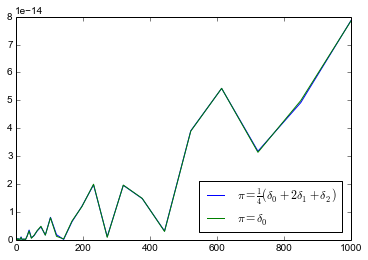

In [23]:
plt.figure(5)
plt.plot(thetas,abs_errs_pi1, label = '$\\pi = \\frac{1}{4}(\delta_0 + 2\delta_1 + \delta_2)$')
plt.plot(thetas,abs_errs_pi2, label = '$\\pi = \delta_0$')
plt.legend(bbox_to_anchor=(0.99, 0.29))
plt.show()
plt.close()

The error-pattern in the above figure seems reasonable, and does not cause me any great concern, and it does not seem unreasonable to ascriibe the small discrepancy detected between the two models to numerical error.